## Landmark based registration and Statistical Shape Analysis

**Deadline**: Send this notebook (rename it as 'TP-ImaReg-LandmarkSSM-YOUR-SURNAME.ipynb') to pietro.gori@telecom-paris.fr. You have one week.

**Goal**: The goal of this notebook is to implement the algorithms seen today for landmarks based registration and statistical shape analysis. Please complete the code where you see **XXXXXXXXXXXXXX** and answer the questions.

We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) which is composed of several facial images annotated with 68 landmarks (already estimated and placed). Below, you will find a picture with an example. People express two emotions, either neutral or happy.

In [28]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA


Now, let's load the data. 

We have a list of images, the position of the landmarks (aligned to the images), the class labels Y (0 for neutral and 1 for happy) and the names of the images.

In [30]:
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks   
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = Landmarks.shape # number subjects 
dim = 2
M = int(M/dim) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

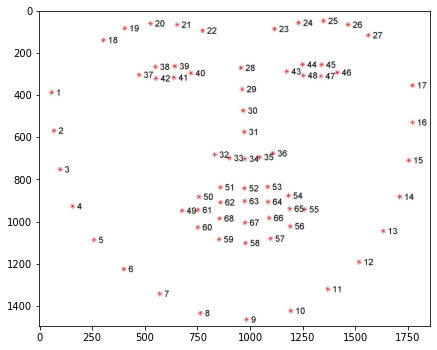

In [31]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (7,7)) # Size of the plot
plt.imshow(Example)
plt.show()

We randomly shuffle the data (even if it is not necessary for the TP)

In [32]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
np.random.shuffle(indeces)

X=Landmarks[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]] 


and we plot the first 6 (random) images with their respective landmarks

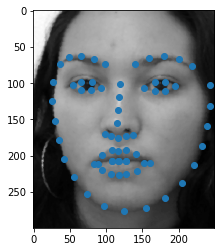

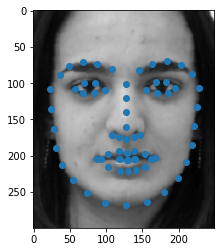

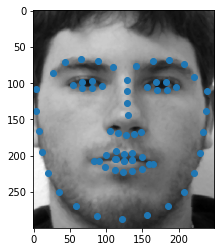

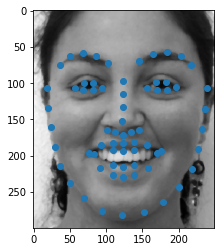

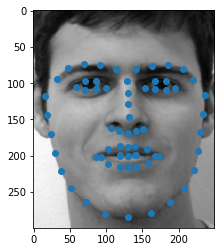

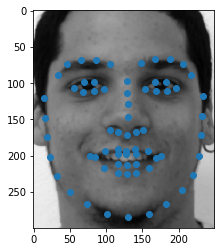

In [33]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

Now it's time to implement first the affine transformation and then the procrustes alignement (similarity transformation).
Please complete the code.

In [34]:
def AffineRegistrationLandmarks(x,y):
    
    '''
    Inputs: 
               x: [M,2] array containing the M 2-dim source landmarks
               y: [M,2] array containing the M 2-dim target landmarks
    
    Outputs:
               xp: [M,2] array containing the M 2-dim aligned source landmarks
               T: [3,3] transformation matrix
    
    '''

    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    N=x.shape[1]

    x01=np.zeros((M,N+1))
    for i in range(0,M): 
      x01[i]=np.append(x[i],[[1]])
    x02=np.zeros((M,N+4))
    for i in range(0,M): 
      x02[i]=np.append(x01[i],[[0,0,0]])
    x03=np.zeros((M,N+4))
    x0=np.zeros((M,3))
    for i in range(0,M):
      x03[i]= np.append(x0[i], values = x01[i], axis= 0)
    xf=np.zeros((M*2,N+4))
    xf=np.append(x02, x03,axis=0)
    My,Ny= y.shape
    y1=np.zeros((My,1))
    y2=np.zeros((My,1))
    for i in range(0,My): 
      y1[i]=y[i][0]
      y2[i]=y[i][1]
    yf=np.zeros((My*2,1))
    yf=np.append(y1, y2,axis=0)

    T_ = np.linalg.inv(xf.T.dot(xf)).dot(xf.T).dot(yf)
    T = np.array([[T_[0], T_[1], T_[2]], [T_[3], T_[4], T_[5]], [0, 0, 1]])
    A = np.array([[T_[0], T_[1]], [T_[3], T_[4]]])
    points0=np.zeros((M, N+1))
    for i in range(0,M): 
      points0[i]=np.append(x[i],[[1]])
    pm=np.zeros((M, 2))
    for i in range(0,M):
      pm1=T.dot(points0[i])
          
      pm[i]=pm1[:2]
        # If homography, ...
    if T[2][0]!=0 and T[2][1]!=0: 
      for i in range (0,N):
        pm[i][0]=points0[i][0]/((points0[i][0]*T[2][0])+(points0[i][0]*T[2][1])+1)
        pm[i][1]=points0[i][1]/((points0[i][0]*T[2][0])+(points0[i][1]*T[2][1])+1)

    xp=pm
    

    return xp,T


Let's test your implementation and see if it works.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


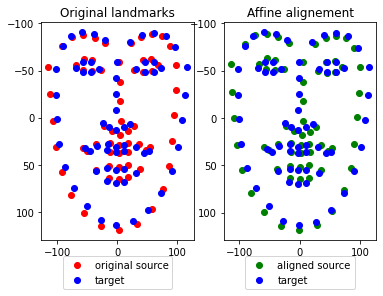

In [44]:
# Choose two random indeces between 0 and N-1
indexSource = 10#int(np.random.uniform(0,N-1,1))
indexTarget = 120#int(np.random.uniform(0,N-1,1))
# Choose if you want to plot data or not
show_plot=1

# Procrustes superimposition of two configurations    
ls = X[indexSource] # source configuration
Is = Imagesp[indexSource,:,:]
lt = X[indexTarget] # target configuration
It = Imagesp[indexTarget,:,:]

# reshape landmarks configurations as matrices [M,2]
xs=np.reshape(ls,(M,dim))
xt=np.reshape(lt,(M,dim))

xpA,TA=AffineRegistrationLandmarks(xs,xt)
#print(TA)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xpA[:,0], xpA[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Affine alignement')

Now, let's implement the procrustes alignement following the inputs and rules explained in the header of the function. 

In [45]:
def procrustes_align(x,y,mode='best',verbose=1):

    """ 
    Inputs: 
               X: [M,2] array containing the M 2-dim source landmarks
               Y: [M,2] matrix containing the M 2-dim target landmarks
               mode: 'rotation' to have only rotation, 'reflection' to
                   have only reflection and 'best' to have the one decided by the
                   data depending on det(U*V')
               verbose: 1 to have explanations and 0 otherwise
    
    Outputs:
               Xp: [M,2] array containing the aligned source landmarks
               s: uniform scaling
               R: rotation or reflection matrix
               t: translation vector
               SSR: sum of squared of residuals
               ratio_SSR: ratio of SSR with respect to the initial SSR
    
    """
    
    if mode.lower()!='best' and mode.lower()!='rotation' and mode.lower()!='reflection':
        raise NameError('Error ! mode should be equal to best, rotation or reflection')   
    
    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    
    # Center data
    xmean= x.mean(axis = 0)
    ymean = y.mean(axis = 0)
    # subtract mean point
    xc = x-xmean
    yc = y-ymean
    
    # Scale to equal unit size 
    #If i scale both here and S the code doesn't work properly, it scale two times all the points
    '''
    sX = (xc**2.).sum()
    sY = (yc**2.).sum()
    normX = np.sqrt(sX)
    normY = np.sqrt(sY)
    xc = xc/np.linalg.norm(xc)
    yc = yc/np.linalg.norm(yc)
    '''
     # Optimal parameters (hint: use np.linalg.svd)
    U, D, Vt = np.linalg.svd(xc.T.dot(yc))
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2) 
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection but a rotation is computed as requested.')               
            S=np.array([[1, 0], [0, np.linalg.det(U@Vt)]]) # to have det(U*V')=1
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation but a reflection is computed as requested.')               
            S=np.array([[1, 0], [0, -np.linalg.det(U@Vt)]]) # to have det(U*V')=-1
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'best':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2)
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    
    S = np.array([[1,0],[0,np.linalg.det(U.dot(Vt))]])
    R= U.dot(S.dot(Vt))
    s=np.matrix.trace(S.dot(np.diag(D)))/np.power(np.linalg.norm(xc),2)
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(R)-1)>1e-5:
            raise NameError('Error ! there is a problem...')
    if mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(R)+1)>1e-5:
            raise NameError('Error ! there is a problem...')
    
    t = ymean -np.dot(s*R,xmean)
    xp = (s*np.dot(x, R)) +t
    # Procrustes residuals
    SSR = np.sum(np.power((y-xp),2))
    # Ratio with initial residual
    SSR0 = np.sum(np.power((y-x),2))
    ratioSSR = (SSR/SSR0)*100


    return xp, s, R, t, SSR, ratioSSR

The best R is a rotation. Computing rotation.


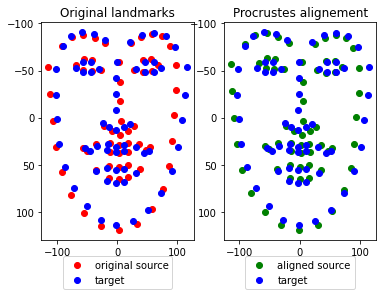

In [46]:
xp, s, R, t, SSR, ratioSSR = procrustes_align(xs,xt)
if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xp[:,0], xp[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Procrustes alignement')

**QUESTIONS**

* 1)  What happens if you center the configurations before the alignment ?
* 2)  When do you expect a perfect alignment ?

**RESPONSES**

* 1) Not centring the landmarks before alignment creates a greater scattering of points after the procrustee has been applied.
* 2) A perfect alignment can be expected when the proportions (or ratios) of distance of each landmark to the others in one set are the same as in the second set

Now, using the functions implemented in the previous jupyter-notebook apply the transformation computed with the affine and/or procrustes alignement to the source image.

In [47]:
def nearestNeighboutInterp(pM,I,coords=None):
    ''' 
    Nearest Neighbout interpolation
        
    Inputs: 
        pM: 2D point defining the coordinates to interpolate
        I: image used for interpolation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
                    
    Output:
        value: interpolated value at pM
    ''' 
    
    if coords is None:
        # row and column of pM
        r = pM[0]
        c = pM[1]
        
        # check if r and c are within the domain of I (I.shape)
        if r >= 0 and r+1 < I.shape[0] and c >= 0 and c+1 < I.shape[1]:
            value = I[int(np.round(r)), int(np.round(c))]
        else:
            value=0
        
    else:
        raise ValueError("Error ! Still not implemented")
        value=0
        
    return value

def InverseWarping(I,T,coords=None,outputShape=None):
    ''' 
    Apply inverse warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB', 
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)
        
            
    Output:
        J: transformed image
    ''' 
    
    if coords is None:
        
        if outputShape is None:
            outputShape=(0,I.shape[0],0,I.shape[1])
            
        elif outputShape == 'BB':
            coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates
            cm = applyTransformation(T,coords=coords)[1]
            #Find extremities bounding box
            bx=int(np.floor(np.min(cm[0,:,:])))
            ux=int(np.ceil(np.max(cm[0,:,:])))
            by=int(np.floor(np.min(cm[1,:,:])))
            uy=int(np.ceil(np.max(cm[1,:,:])))
            outputShape=(bx,ux,by,uy)
            
        elif isinstance(outputShape, tuple):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")           
                
        elif isinstance(outputShape, np.ndarray):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")                                      
        else:
            raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")       
                                 
        J= np.zeros((outputShape[1]-outputShape[0], outputShape[3]-outputShape[2])) # transformed image
        
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):

                p=np.array([i,j]) # coordinate of a pixel to transform
                pM = applyTransformation(np.linalg.inv(T),points=p.reshape((p.shape[0], 1)).T)[0][0] # transformed coordinate

                if pM[-1] != 0: 
                 # pM = XXXXXXXXXXXXXX # normalization in case of homography

                  # shifting since the first pixel will be in (0,0) in the output image
                  if outputShape[0]<0:
                      x=i+abs(outputShape[0])
                  else:
                      x=i
                  if outputShape[2]<0:
                      y=j+abs(outputShape[2])
                  else:
                      y=j
                      
                  J[x,y]=nearestNeighboutInterp(pM,I)
    
    else:
        raise ValueError("Error ! Still not implemented")
        
    return J

In [48]:
def applyTransformation(T, points=None, coords=None):
    '''
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        points: Nx2 Numpy array of points 
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation
            
    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    '''
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")
    
    if points is not None:    
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape  
        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")  
        # Transform points into homogeneous coordinates (adding one...)
        
        points0=np.zeros((N, d+1))
        for i in range(0,N): 
          points0[i]=np.append(points[i],[[1]])
        pm=np.zeros((N, 2))
        for i in range(0,N):
          pm1=T.dot(points0[i])
          
          pm[i]=pm1[:2]
        # If homography, ...
        if T[2][0]!=0 and T[2][1]!=0: 
          for i in range (0,N):
            pm[i][0]=points0[i][0]/((points0[i][0]*T[2][0])+(points0[i][0]*T[2][1])+1)
            pm[i][1]=points0[i][1]/((points0[i][0]*T[2][0])+(points0[i][1]*T[2][1])+1)

        #pm=1#XXXXXXXXXXXXXX
        
    else:
        pm=None
     
    if coords is not None:
        d,N,M = coords.shape
        
        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")
        
        p = coords.reshape((2,N*M)).T # reshape coordinates as list of points
        
        # Transform points into homogeneous coordinates (adding one...)
       # XXXXXXXXXXXXXX
        points01=np.zeros((N*M, d+1))
        for i in range(0,N*M): 
          points01[i]=np.append(p[i],[[1]])
        pm=np.zeros((N*M, 2))
        
        # Apply transformation
       # XXXXXXXXXXXXXX
        
        for i in range(0,N*M):
          pm11=T.dot(points01[i])
          pm11=pm11
          pm[i]=pm11[:2]
    
        # If homography, ...
        if T[2][0]!=0 and T[2][1]!=0: 
          for i in range (0,N*M):
            pm[i][0]=points01[i][0]/((points01[i][0]*T[2][0])+(points01[i][0]*T[2][1])+1)
            pm[i][1]=points01[i][1]/((points01[i][0]*T[2][0])+(points01[i][1]*T[2][1])+1)

      #pm=1#XXXXXXXXXXXXXX
        pm=pm.T
        cm = pm.reshape((2,N,M))

    else:
        cm =None         
    return pm,cm


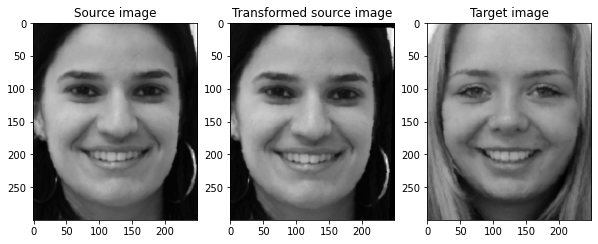

In [49]:
# compute T       
T = np.array([
            [s*R[0,0], s*R[0,1], t[0]],
            [s*R[1,0], s*R[1,1], t[1]],
            [0, 0, 1]
            ])
    
Ism=InverseWarping(Is,T,outputShape=None)

fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(Is, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Ism, cmap='gray')
ax2.set_title('Transformed source image')
ax3.imshow(It, cmap='gray')
ax3.set_title('Target image')
plt.show() 

Now let's implement the Generalized Procrustes Analysis (GPA) using the previously implemented procrustes alignement function.

As before, please follow the inputs and rules explained in the header of the function.

In [51]:
def generalized_procrustes_analysis(X,tau=1e-5,tangent=1):
  """
  Inputs: 
            X: [N,2M] array containing N configurations of 2D landmarks. 
               Each configuration has M landmarks
            tau: parameter for the stopping criteria (please refer to the slides 
                 of the course)
            tangent: if set to 1, data will be projected onto the tangent space

  Outputs: 
            Xm1: [M,2] array containing the landmarks of the average configuration
            Xcp: [N,2M] array containing the aligned landmarks onto Xm1

  """

  if X.shape[1] % 2 != 0:
        raise NameError('This code works only for 2 dimennsional data')        
          
  # Parameters
  N,M=X.shape
  dim=2
  M=int(M/dim)

  # Plot original data
  plt.figure()    
  for i in range(0,N):
      landmark=X[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r') 
  plt.gca().invert_yaxis()     
  plt.title('Original landmarks')


  # Center each configuration
  Xc=np.zeros((N,M*dim))
  for i in range(0,N):
    
    landmark = X[i]
    x=landmark[::2]
    y=landmark[1::2]
        
    x -= np.mean(x)
    y -= np.mean(y)
        
    lc = np.zeros((2*M))
    lc[::2] = x
    lc[1::2] = y
    Xc[i] = np.reshape(lc,(M*dim))
    
    #Xc[i] = X[i] - X.mean()
      
      
  # Compute first average configuration
  Xm0 = Xc.mean(axis=0)

  # Plot configurations and first average    
  plt.figure()    
  for i in range(0,N):
    #XXXXXXXXXXXXX
      landmark=Xc[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r')       
  plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average')    
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
  plt.gca().invert_yaxis() 
  plt.title('Centered data with first average') 

  # Normalize average
  Xm0 /= np.linalg.norm(Xm0)


  # Procrustes alignement of all configurations to the average Xm0
  Xcp=np.zeros((N,M*dim))
  
  for i in range(0,N):
      #XXXXXXXXXXXXXXXX
      Xcp[i] = np.array(procrustes_align(X[i].reshape((M,2)),Xm0.reshape((M,2)))[0]).reshape((-1))

      
  # Reshape average as vector
  Xm0 = np.reshape(Xm0,(M*dim))
      
  # Plot configurations and average    
  plt.figure()    
  for i in range(0,N):
      landmark=Xcp[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r') 
  plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average')  
  plt.gca().invert_yaxis()   
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
  plt.title('Aligned data to normalized initial mean')    

  # Tangent space projection
  if tangent==1:
      # landmarks after tangent space projection
      Xcpt=np.zeros((N,M*dim))
      # vector measuring the difference before/after projection
      diff = np.zeros((N,1))
      
      for i in range(0,N):
          Xcpt[i] = Xcp[i] / (Xcp[i].dot(Xm0.T))
          mse=np.array(np.power((Xcpt[i] - Xcp[i]),2))
          diff[i]= np.sum(mse)
          
      # we look for the subject with the maximum difference before/after projection    
      ind=np.argmax(diff)
          
      # Plot configurations and first average
      plt.figure()
      l=Xcp[ind]
      lt=Xcpt[ind]
      plt.scatter(l[::2], l[1::2], c='r', label='before projection')  
      plt.scatter(lt[::2], lt[1::2], c='b', label='after projection') 
      plt.gca().invert_yaxis() 
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
      plt.title('Subject with maximum variation')        

      plt.figure()
      for i in range(0,N):
          landmark=Xcp[i]
          x=landmark[::2]
          y=landmark[1::2]        
          if i==ind:
              plt.scatter(x, y, c='b',label='Subject with max distortion', zorder=10)
          else:
              plt.scatter(x, y, c='r')
              
      plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average', zorder=5)   
      plt.gca().invert_yaxis()  
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
      plt.title('Subjects before projection')  
      
      Xcp=Xcpt

  # Re-estimate average configuration
  Xm1=Xcp.mean(axis=0)

  # Procrustes alignement of Xm1 to Xm0 
  Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1,(M,dim)) ,np.reshape(Xm0,(M,dim)),'best',0)

  # Normalize new average Xm1 
  #XXXXXXXXXXXXXXXX
  Xm1 = np.array(Xm1)
  Xm1 /= np.linalg.norm(Xm1) 
  # Reshape average as vector
  Xm1=Xm1.reshape((-1))
  #XXXXXXXXXXXXXXXX

  # Plot configurations and new average    
  plt.figure()    
  for i in range(0,N):
      landmark=Xcp[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r') 
  plt.scatter(Xm1[::2],Xm1[1::2],c='g',label='average')   
  plt.gca().invert_yaxis()  
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
  plt.title('Aligned data to new mean')   


  itera=1    
  while np.sqrt(np.dot((Xm0-Xm1),(Xm0-Xm1))) > tau:

      print('Iter number %d , Error: %f' % (itera, np.sqrt(np.dot((Xm0-Xm1),(Xm0-Xm1))) ) )
      itera=itera+1
      
      # Update Xm0 to Xm1
      Xm0=Xm1
      
      # Procrustes alignement of all configurations to the average Xm0        
      for i in range(0,N):
          temp=np.reshape(Xc[i],(M,dim))
          xp, s, R, t, SSR, ratioSSR = procrustes_align(temp,np.reshape(Xm0,(M,dim)),'best',0)
          Xcp[i]=np.reshape(xp,(M*dim))
          
      # Tangent space projection
      if tangent==1:            
        for i in range(0,N):#XXXXXXX
          #Xcptmp[i]= np.dot(np.inner(np.linalg.norm(Xm0tmp),np.linalg.norm(Xm0tmp))/np.dot(Xcpt[i], Xm0tmp), Xcpt[i]) # in our case np.dot(Xm0,Xm0)=1
          Xcp[i] = Xcp[i] / (Xcp[i].dot(Xm0.T))
      # Re-estimate average configuration
      #XXXXXXXXXXX
      Xm1=Xcp.mean(axis=0)
      
      # Procrustes alignement of Xm1 to Xm0 
      Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1,(M,dim)),np.reshape(Xm0,(M,dim)),'best',0)
      
      # Normalize new average Xm1 
       #XXXXXXXXXXXXXXXX
      Xm1 = np.array(Xm1)
      Xm1 /= np.linalg.norm(Xm1)
      
      # Reshape average as vector
      Xm1=np.reshape(Xm1,(M*dim))
      
      # Plot configurations and new average    
      plt.figure()    
      for i in range(0,N):
          landmark=Xcp[i]
          x=landmark[::2]
          y=landmark[1::2]        
          plt.scatter(x, y, c='r') 
      plt.scatter(Xm1[::2],Xm1[1::2],c='g',label='average')  
      plt.gca().invert_yaxis()   
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
      plt.title('GPA results after iter %i' % itera)
      

  return Xcp, Xm1 


Let's test your implementation and see if it works.

The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computing rotation.
The best R is a rotation. Computin

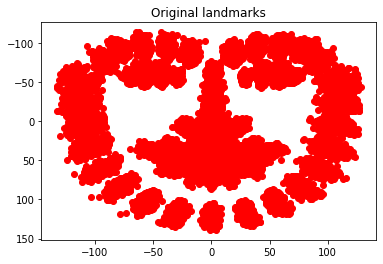

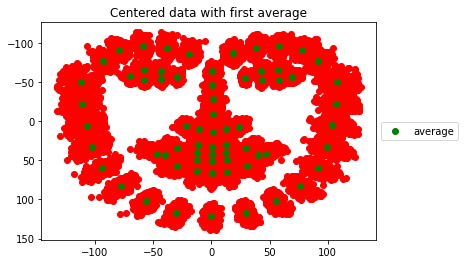

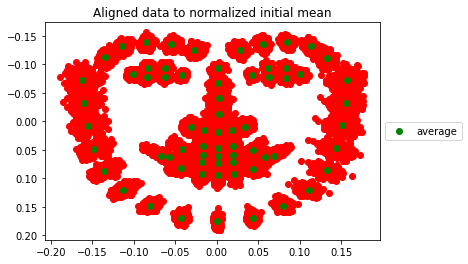

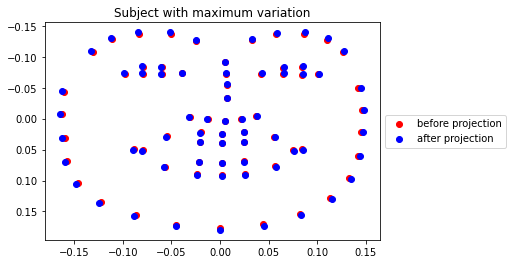

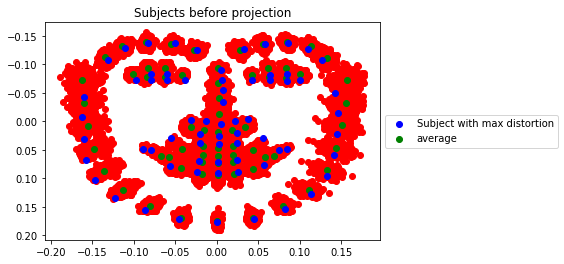

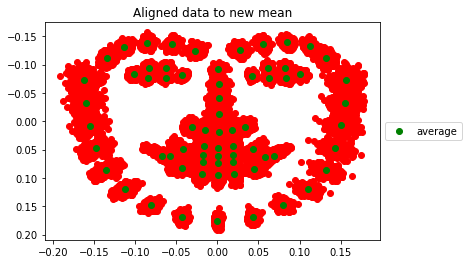

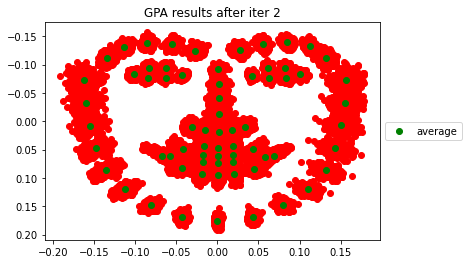

In [52]:
#  GPA (Generalized Procrustes Analysis)
Xcp, Xm1  = generalized_procrustes_analysis(X)   

**QUESTIONS**


*   1) Try not to project the data onto the tangent space (i.e. `tangent=0`). Do the results vary ? Why in your opinion ? Hint: Look at the variability of the original data...
*   2) Do the following four triangles have the same shape ? Explain why ?

![shape.png](https://drive.google.com/uc?id=10OSJUfNDJ1xw6H3sRu7l3LRoojxju_4L)

**RESPONSES**

* 1) The fact of carrying out the project on the tangent makes it possible to remove the non-linearities induced by the procrustean analysis (and thus to restore lines)
* 2) The first 3 triangles are the same because if we define each corner of these triangles as a "landmark", the shapes are equivalent after the application of "procruste " since they have the same proportions. The differences between these triangles are: rotation, reflection, size and translation
The last triangle doesn't seem to have the same proportion of the others, expecially the angle seems bigger. 



Let's compute the shape variability using PCA. You will compute the three modes of deformations, as described in the slides of the lecture, at $\pm 3 \sigma$, where $\sigma$ is the standard deviation thus the square root of the the relative eigenvalue 

[2.96852603e+01 2.51405186e+01 1.25471507e+01 1.06556735e+01
 3.74529406e+00 3.19106970e+00 2.94090142e+00 1.97036123e+00
 1.47214646e+00 1.18466619e+00 9.27310600e-01 8.15517010e-01
 7.45372073e-01 5.68104979e-01 4.88247017e-01 3.86788986e-01
 3.58141605e-01 3.32745275e-01 3.12813037e-01 2.80825714e-01
 2.35247555e-01 2.27643089e-01 1.76859095e-01 1.63455290e-01
 1.08728979e-01 1.04190296e-01 9.90922684e-02 7.96963371e-02
 7.42041583e-02 6.73495207e-02 6.31083461e-02 6.04037061e-02
 5.22868210e-02 4.60575105e-02 4.05378801e-02 3.43387533e-02
 3.33238256e-02 3.06031801e-02 2.87014260e-02 2.38857877e-02
 2.35015749e-02 2.09628888e-02 1.86798024e-02 1.82463269e-02
 1.61961038e-02 1.53598306e-02 1.34297194e-02 1.31310737e-02
 1.25554010e-02 1.16079256e-02 1.13276982e-02 1.08174970e-02
 9.93142490e-03 9.25295485e-03 8.77124556e-03 8.19916841e-03
 8.00806108e-03 7.98432948e-03 7.70908796e-03 7.48362948e-03
 7.31265430e-03 7.25804483e-03 6.94428768e-03 6.50881792e-03
 6.34253784e-03 6.214590

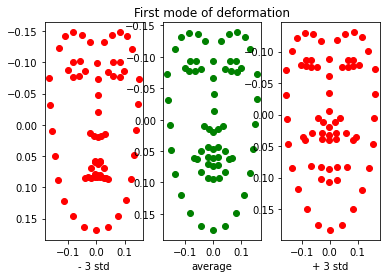

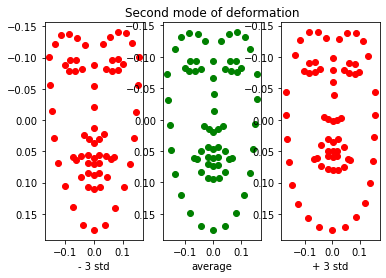

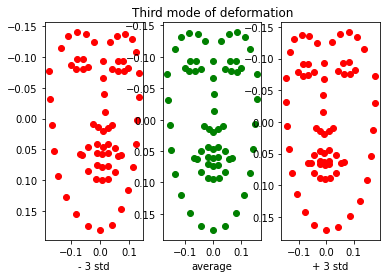

In [53]:
#%% Shape variability analysis
# we will use the scikit-learn implementation for PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y=pca.fit_transform(Xcp)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues
var_explained = pca.explained_variance_ratio_*100 # variance explained
print(var_explained)
print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained[0], var_explained[1], var_explained[2]))

# Compute first mode
first_mode_m= Xm1 - 3 * np.sqrt(D[0]) * U[:,0]
first_mode_p= Xm1 + 3 * np.sqrt(D[0]) * U[:,0]
# Compute second mode
second_mode_m= Xm1 - 3 * np.sqrt(D[1]) * U[:,1]
second_mode_p= Xm1 + 3 * np.sqrt(D[1]) * U[:,1]
# Compute third mode
third_mode_m= Xm1 - 3 * np.sqrt(D[2]) * U[:,2]
third_mode_p= Xm1 + 3 * np.sqrt(D[2]) * U[:,2]

if show_plot==1:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r') 
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average') 
    plt.title('First mode of deformation') 
    plt.gca().invert_yaxis()    
    plt.subplot(1, 3, 3)
    plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std') 
    plt.gca().invert_yaxis() 
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r') 
    plt.xlabel('- 3 std') 
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average') 
    plt.title('Second mode of deformation')    
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 3)
    plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std') 
    plt.gca().invert_yaxis() 

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r') 
    plt.xlabel('- 3 std') 
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average') 
    plt.title('Third mode of deformation')    
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 3)
    plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std') 
    plt.gca().invert_yaxis() 


**QUESTIONS**


*   1) How many modes do you need to explain 90% of the variability ?
*   2) Which anatomical variability do the first three modes show ? Was it expected ?
*   3) How could you check whether they show an anatomically plausible deformation ? 
*   4) Let's say that the anatomical deformation is not anatomically plausible, which kind of deformation would you use instead ? Why ?

**RESPONSES**

* 1) To explain 90% of the variability it is sufficient to sum var_explained until 90% is reached (which in our case is 9).
* 2A) The first modes show in order :
  * Smiling or sad espression.
  * Short distance between chin and mouth, long distance between chin and mouth 
  * Turning the head to the left or right.
  * Having an open mouth and raised eyebrows or lowered eyebrows and closed mouth.
  * Eyebrow position.
* 2B) These results were to be expected as these are the anatomical factors that make the most variation from one face image to another (and the most common variations).
* 3) One can verify that these are plausible anatomical deformations by looking for a set of landmarks in the dataset close to and/or performing these face variations.
* 4) If the transformations are not anatomically plausible, then one can use deformations based on the distance between the average face and the faces with the greatest variance. 


